In [60]:
# DEPENDENCIAS
!pip install torchviz

In [61]:
# LIBRERIAS
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.nn as nn

In [62]:
# CARGAR DATOS
data = pd.read_excel("/content/pems08_dataframe_30nodes.xlsx", sheet_name="Sheet1")
data

sensor    0  Unnamed: 2  Unnamed: 3    1  Unnamed: 5  \
0                 variable    0      1.0000         2.0    0      1.0000   
1      2016-07-01 00:00:00  133      0.0603        65.8  210      0.0589   
2      2016-07-01 00:05:00  114      0.0532        66.9  185      0.0550   
3      2016-07-01 00:10:00  140      0.0622        66.8  171      0.0466   
4      2016-07-01 00:15:00  106      0.0452        68.9  174      0.0529   
...                    ...  ...         ...         ...  ...         ...   
17852  2016-08-31 23:35:00  131      0.0610        63.9  191      0.0566   
17853  2016-08-31 23:40:00  134      0.0658        62.7  183      0.0548   
17854  2016-08-31 23:45:00  120      0.0581        63.3  176      0.0529   
17855  2016-08-31 23:50:00  102      0.0579        61.4  165      0.0492   
17856  2016-08-31 23:55:00  102      0.0565        61.7  166      0.0502   

       Unnamed: 6    2  Unnamed: 8  Unnamed: 9  ...  Unnamed: 84   28  \
0             2.0    0      1.0000         2.0  ...          2.0    0   
1            69.6  124      0.0358        65.8  ...         62.0   86   
2            68.5  119      0.0339        65.0  ...         62.2   86   
3            69.9  107      0.0336        63.8  ...         66.3   86   
4            68.0   98      0.0326        63.5  ...         62.8   83   
...           ...  ...         ...         ...  ...          ...  ...   
17852        66.5  149      0.0540        54.5  ...         69.0  113   
17853        66.7  137      0.0500        56.1  ...         66.1  130   
17854        66.8  119      0.0518        56.1  ...         66.9  135   
17855        67.2  133      0.0507        58.9  ...         66.5  114   
17856        67.6  133      0.0464        56.3  ...         67.4  130   

       Unnamed: 86  Unnamed: 87   29  Unnamed: 89  Unnamed: 90   30  \
0           1.0000          2.0    0       1.0000          2.0    0   
1           0.0229         68.5  150       0.0400         63.3  223   
2           0.0226         68.2  171       0.0422         64.1  226   
3           0.0225         68.0  164       0.0391         65.9  215   
4           0.0218         67.9  164       0.0393         66.2  186   
...            ...          ...  ...          ...          ...  ...   
17852       0.0415         66.1  224       0.0428         63.5  181   
17853       0.0448         67.0  225       0.0467         62.8  170   
17854       0.0460         67.3  196       0.0385         64.2  178   
17855       0.0425         66.2  221       0.0434         64.5  165   
17856       0.0456         66.2  196       0.0407         63.2  169   

       Unnamed: 92  Unnamed: 93  
0           1.0000          2.0  
1           0.0398         69.5  
2           0.0377         71.1  
3           0.0388         70.3  
4           0.0350         68.0  
...            ...          ...  
17852       0.0521         63.9  
17853       0.0509         64.4  
17854       0.0500         66.0  
17855       0.0498         65.1  
17856       0.0464         64.9  

[17857 rows x 94 columns]

In [63]:
# CORREGIR DATASET
df_aux = data.copy()
df_aux = df_aux.iloc[:, 1:] # eliminar la columna del sensor
df_aux = df_aux.iloc[1:, :] # eliminar la fila del sensor
df_aux.columns = range(df_aux.shape[1])
# La estructura es:
# Flow_N1|Occ_N1|Speed_N1|...|Flow_N30|Occ_N30|Speed_N30|
df_aux

0       1     2    3       4     5    6       7     8    9   ...  \
1      133  0.0603  65.8  210  0.0589  69.6  124  0.0358  65.8  145  ...   
2      114  0.0532  66.9  185  0.0550  68.5  119  0.0339  65.0  184  ...   
3      140  0.0622  66.8  171  0.0466  69.9  107  0.0336  63.8  146  ...   
4      106  0.0452  68.9  174  0.0529  68.0   98  0.0326  63.5  148  ...   
5      117  0.0574  67.4  176  0.0484  68.7  114  0.0348  63.1  130  ...   
...    ...     ...   ...  ...     ...   ...  ...     ...   ...  ...  ...   
17852  131  0.0610  63.9  191  0.0566  66.5  149  0.0540  54.5  140  ...   
17853  134  0.0658  62.7  183  0.0548  66.7  137  0.0500  56.1  151  ...   
17854  120  0.0581  63.3  176  0.0529  66.8  119  0.0518  56.1  142  ...   
17855  102  0.0579  61.4  165  0.0492  67.2  133  0.0507  58.9  133  ...   
17856  102  0.0565  61.7  166  0.0502  67.6  133  0.0464  56.3  116  ...   

         83   84      85    86   87      88    89   90      91    92  
1      62.0   86  0.0229  68.5  150  0.0400  63.3  223  0.0398  69.5  
2      62.2   86  0.0226  68.2  171  0.0422  64.1  226  0.0377  71.1  
3      66.3   86  0.0225  68.0  164  0.0391  65.9  215  0.0388  70.3  
4      62.8   83  0.0218  67.9  164  0.0393  66.2  186  0.0350  68.0  
5      61.1   79  0.0211  67.8  136  0.0375  64.9  187  0.0316  70.2  
...     ...  ...     ...   ...  ...     ...   ...  ...     ...   ...  
17852  69.0  113  0.0415  66.1  224  0.0428  63.5  181  0.0521  63.9  
17853  66.1  130  0.0448  67.0  225  0.0467  62.8  170  0.0509  64.4  
17854  66.9  135  0.0460  67.3  196  0.0385  64.2  178  0.0500  66.0  
17855  66.5  114  0.0425  66.2  221  0.0434  64.5  165  0.0498  65.1  
17856  67.4  130  0.0456  66.2  196  0.0407  63.2  169  0.0464  64.9  

[17856 rows x 93 columns]

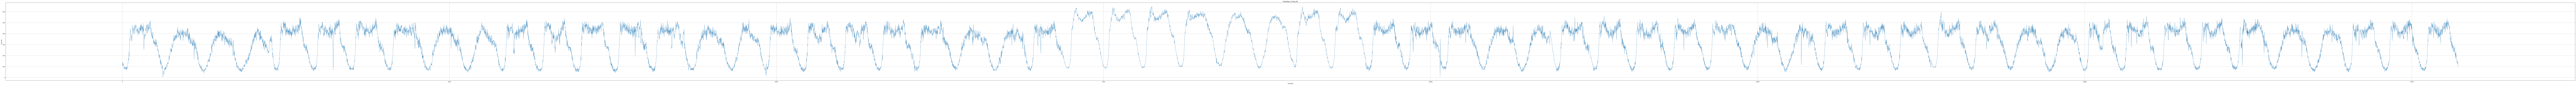

In [64]:
# GRAFICAR UNA FEATURE DE UN NODO
# Definir timesteps
y = df_aux.iloc[:, 0]
# Crear grafico
plt.figure(figsize=(300, 10))
plt.plot(df_aux.index, y, linewidth=1)
plt.xlabel('TimeStep')
plt.ylabel("Flow_N1")
plt.title("TimeStep vs Flow_N1")
plt.grid(True)
plt.tight_layout()
plt.show()

In [65]:
# OBTENER TARGETS
F = df_aux.shape[1]                    # Total features
targets_idx = list(range(0, F, 3))     # [0, 3, 6, ..., 90] seleccionar indices solo de las features de flow
TGT = len(targets_idx)                 # Definir cantidad de targets de flow
# SPLIT DE VALORES Xs E Ys
X_all = df_aux.values.astype('float32')                       # (Muestras N, 93)
y_all = df_aux.iloc[:, targets_idx].values.astype('float32')  # (Muestras N, 31) Targets
# SPLIT DE TRAIN Y TEST
N = len(df_aux)                                         # Numero de muestras
split = int(N * 0.8)                                    # 80/20 (train/test)
X_train_2D, X_test_2D = X_all[:split], X_all[split:]
y_train_2D, y_test_2D = y_all[:split], y_all[split:]

In [66]:
# ESCALAR LOS DATOS
scaler_X = StandardScaler().fit(X_train_2D)
scaler_y = StandardScaler().fit(y_train_2D)

X_all_sc = scaler_X.transform(X_all)   # (N, 93)
y_all_sc = scaler_y.transform(y_all)   # (N, 31)

In [67]:
# CONSTRUIR SECUENCIAS NUMERICAS
# Funcion de secuencias
def build_sequences(X2D, Y2D, ventana=60, horizonte=1):
    # X2D: (N, F) (Muestras, Features)
    # Y2D: (N, TGT) (Muestras, Targets)
    Xs, Ys = [], []
    N = X2D.shape[0]
    for i in range(N - ventana - horizonte + 1):
        Xs.append(X2D[i:i+ventana, :])                       # (T, F) (Targets, Features)
        Ys.append(Y2D[i + ventana + horizonte - 1, :])       # (TGT,) (Target)
    return np.stack(Xs).astype('float32'), np.stack(Ys).astype('float32')

ventana = 60
horizonte = 1

X_seq, y_seq = build_sequences(X_all_sc, y_all_sc, ventana, horizonte)
# X_seq: (B, T, F) = (N', 60, 93) -----> (Batch, TimeStep, Features)
# y_seq: (B, TGT)  = (N', 31) ---------> (Batch, Target)

# Split en el espacio de secuencias
B = X_seq.shape[0]
split_seq = int(B * 0.8)
Xtr, Xte = X_seq[:split_seq], X_seq[split_seq:]
ytr, yte = y_seq[:split_seq], y_seq[split_seq:]

In [68]:
# DATASET PARA PYTORCH
train_ds = TensorDataset(torch.from_numpy(Xtr), torch.from_numpy(ytr))
test_ds  = TensorDataset(torch.from_numpy(Xte), torch.from_numpy(yte))

train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
test_dl  = DataLoader(test_ds, batch_size=64)

In [69]:
# MODELO LSTM
class LSTM_MODEL(nn.Module):
    def __init__(self, in_features, out_features, hidden_size=128, num_layers=2, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=in_features,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0
        )
        self.fc = nn.Linear(hidden_size, out_features)  # 31 salidas

    def forward(self, x):              # x: (B, T, F)
        out, _ = self.lstm(x)          # (B, T, H)
        last = out[:, -1, :]           # (B, H)
        yhat = self.fc(last)           # (B, out_features) = (B, 31)
        return yhat

In [70]:
# PARAMETROS DEL MODELO
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTM_MODEL(in_features=F, out_features=TGT, hidden_size=128, num_layers=2, dropout=0.2).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [71]:
# LOOP DE ENTRENAMIENTO
def entrenar_epoca():
    model.train()
    total = 0.0
    for xb, yb in train_dl:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        pred = model(xb)               # (B, 31)
        loss = criterion(pred, yb)     # MSE multi-salida
        loss.backward()
        optimizer.step()
        total += loss.item() * xb.size(0)
    return total / len(train_ds)

for epoch in range(50):
    tr_loss = entrenar_epoca()
    print(f"Epoch {epoch+1}: train MSE = {tr_loss:.6f}")

Epoch 1: train MSE = 0.147363
Epoch 2: train MSE = 0.062961
Epoch 3: train MSE = 0.052189
Epoch 4: train MSE = 0.047909
Epoch 5: train MSE = 0.045453
Epoch 6: train MSE = 0.043413
Epoch 7: train MSE = 0.042229
Epoch 8: train MSE = 0.041138
Epoch 9: train MSE = 0.040403
Epoch 10: train MSE = 0.039680
Epoch 11: train MSE = 0.039067
Epoch 12: train MSE = 0.038418
Epoch 13: train MSE = 0.037889
Epoch 14: train MSE = 0.037381
Epoch 15: train MSE = 0.037065
Epoch 16: train MSE = 0.036700
Epoch 17: train MSE = 0.036345
Epoch 18: train MSE = 0.035852
Epoch 19: train MSE = 0.035522
Epoch 20: train MSE = 0.035214
Epoch 21: train MSE = 0.034900
Epoch 22: train MSE = 0.034620
Epoch 23: train MSE = 0.034333
Epoch 24: train MSE = 0.034117
Epoch 25: train MSE = 0.033851
Epoch 26: train MSE = 0.033558
Epoch 27: train MSE = 0.033202
Epoch 28: train MSE = 0.033053
Epoch 29: train MSE = 0.032821
Epoch 30: train MSE = 0.032560
Epoch 31: train MSE = 0.032401
Epoch 32: train MSE = 0.032739
Epoch 33: train M

In [72]:
# EVALUACION DEL MODELO
model.eval()
test_dl_eval = DataLoader(TensorDataset(torch.from_numpy(Xte),
                                        torch.from_numpy(yte)),
                          batch_size=256, shuffle=False)

pred_sc_list = []
true_sc_list = []
with torch.no_grad():
    for xb, yb in test_dl_eval:
        xb = xb.to(device)
        pred_sc_list.append(model(xb).cpu().numpy())
        true_sc_list.append(yb.numpy())

pred_sc = np.vstack(pred_sc_list)   # (N_test, 31) escalado
true_sc = np.vstack(true_sc_list)   # (N_test, 31) escalado

In [73]:
# DESESCALAR LOS DATOS
pred = scaler_y.inverse_transform(pred_sc)
true = scaler_y.inverse_transform(true_sc)

In [74]:
# RECONSTRUIR EL EJE X
# Definir el total de ventanas posibles sobre df
B_total = len(df_aux) - ventana - horizonte + 1
# Ajustar el ratio de split 80/20 que el ejemplo
split_seq = int(B_total * 0.8)
# Usar indices (timestamps) alineados con cada ventana (el target está en i+ventana+horizonte-1)
idx_all = df_aux.index[ventana + horizonte - 1 : ventana + horizonte - 1 + B_total]
idx_te = idx_all[split_seq : split_seq + pred.shape[0]]
# Definir un rango simple como index
x_axis = idx_te if isinstance(idx_te, pd.DatetimeIndex) else np.arange(len(idx_te))

In [75]:
# PARAMETROS PARA GRAFICAR
k = 0 # Fueature predicha de 0 a 30
col_name = str(df_aux.columns[targets_idx[k]]) if hasattr(df_aux, "columns") else f"target_{k}"
# Metricas para la feature 4
mae = mean_absolute_error(true[:, k], pred[:, k])
rmse = mean_squared_error(true[:, k], pred[:, k])
print(f"{col_name} -> MAE: {mae:.4f} | RMSE: {rmse:.4f}")


0 -> MAE: 23.9425 | RMSE: 1136.0455


<Figure size 640x480 with 0 Axes>

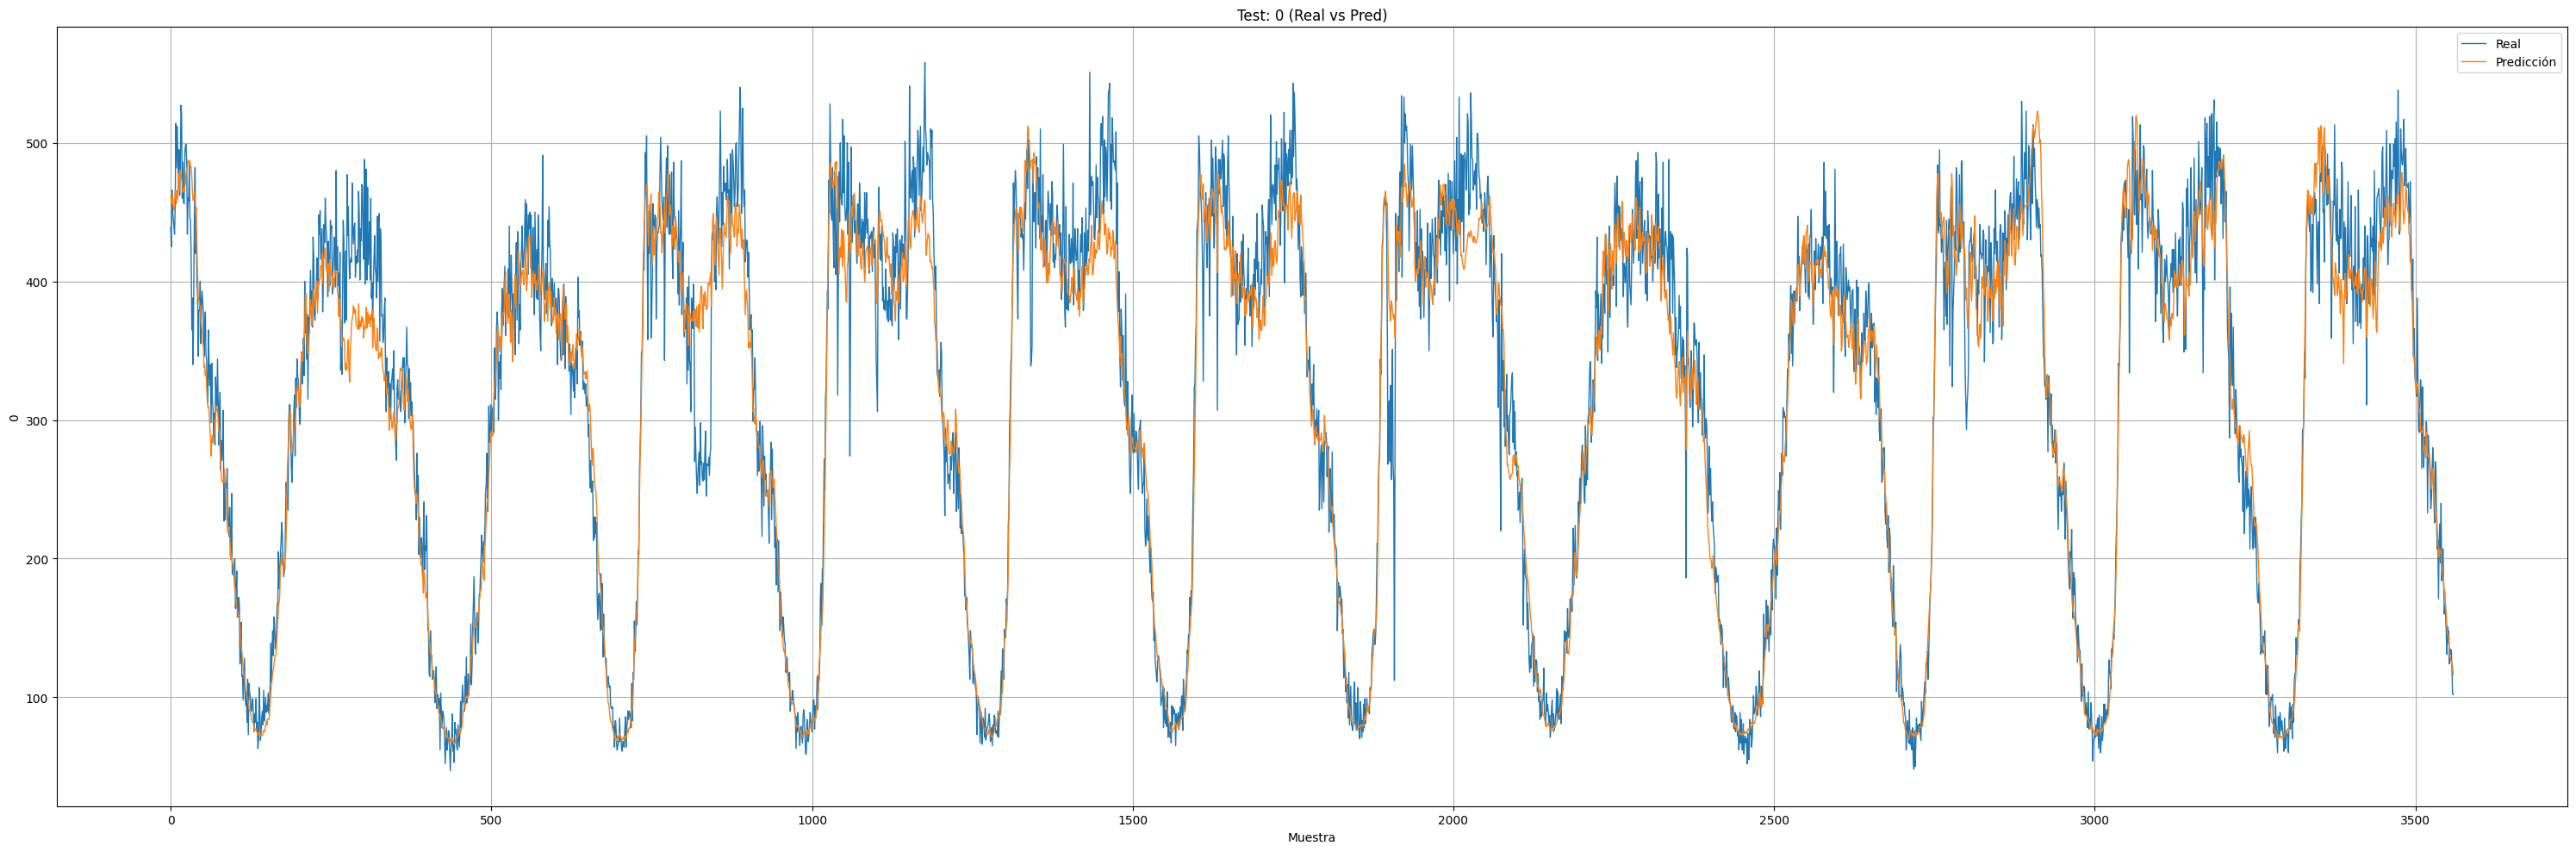

In [81]:
# GRAFICAR LA SERIE DE TIEMPO K
plt.figure()
plt.figure(figsize=(30, 10))
plt.plot(x_axis, true[:, k], label="Real", linewidth=1)
plt.plot(x_axis, pred[:, k], label="Predicción", linewidth=1)
plt.xlabel("Tiempo" if isinstance(idx_te, pd.DatetimeIndex) else "Muestra")
plt.ylabel(col_name)
plt.title(f"Test: {col_name} (Real vs Pred)")
plt.grid(True)
plt.legend()
if isinstance(idx_te, pd.DatetimeIndex):
    plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.savefig("Figura_6.jpg")
plt.show()
